# Executive summary
The Overhead Imagery team handles the processing and publication of satellite data. We receive vast amounts of imagery from providers, which is stored in various Google Cloud storage before QA and publication. Occasionally, flawed data bypasses QA and ends up in the production, resulting in issues like clouds, snow, color inaccuracies, broken scenes, black patches, and telemetry loss. To prevent this, I propose developing a generalized model to automatically detect these issues before publication, ensuring data quality and minimizing escalations.




# Research Questions

**Research Questions and Answers**

**1. Research Question:** What are the most effective feature extraction methods for accurately identifying cloud cover, color inaccuracies, and other defects in satellite RGB imagery using scikit-learn?

* **Answer:**
    * Directly using raw pixel values can be computationally expensive. This needs to be determined through experimentation.
    * **Recommended Approach:**
        * **Color Histograms:** Extract color distribution features.
        * **Texture Analysis (GLCM):** Use Gray-Level Co-occurrence Matrices to capture texture patterns related to cloud cover and other defects.
        * **PCA:** Use PCA  reduce dimension of RGB images.
    * The optimal combination of these techniques should be determined through experimentation also.

**2. Research Question:** How can we optimize the scikit-learn classification model to minimize false positives while maintaining high recall for defect detection?

* **Answer:**
    * **Model Selection:** Experiment with various scikit-learn classifiers, including RandomForestClassifier, Support Vector Machines (SVM), and Logistic Regression.
    * **Hyperparameter Tuning:** Use techniques like GridSearchCV or RandomizedSearchCV to optimize model hyperparameters.
    * **Threshold Adjustment:** If the model outputs probabilities, adjust the classification threshold to balance precision and recall.
    * **Feature Selection:** Use techniques like feature importance or recursive feature elimination to identify and remove irrelevant or redundant features.
    * **Data Augmentation:** augment the training data, to provide more training data for the model.

**3. Research Question:** How does the resolution of the input satellite imagery affect the accuracy of the defect detection model?

* **Answer:**
    * Low-resolution images can lead to increased false positives, as subtle defects may be difficult to discern.
    * **Hypothesis:** Increasing the resolution of the input images will improve the model's accuracy, particularly in reducing false positives.
    * **Testing:** Conduct experiments with images of varying resolutions to evaluate the impact on model performance.


**4. Research Question:** What metrics will be used to measure the success of the model?

* **Answer:**
    * **Accuracy:** Overall correctness of the model.
    * **Precision:** The proportion of correctly identified defects among all predicted defects.
    * **Recall:** The proportion of correctly identified defects among all actual defects.
    * **F1-score:** The harmonic mean of precision and recall.
    * **False positive rate:** the amount of good images that are incorrectly marked as bad.





# Data Sources

* A dataset of 1024x1024 pixel images downloaded from the satellite imagery collection.
* The dataset is categorized into two classes:
    * **Accept:** Images deemed acceptable for publication after QA.
    * **Reject:** Images identified as having defects (clouds, color issues, etc.) and rejected during QA.
* The dataset consists of 1266 images per category, totaling 2532 images.
* Images are in JPEG format.

* Images are also converted to 512x512 and 256x256 using below command in the ubuntu

* Example: Convert accept images to 256 x 256
```
convert "accept/*.jpeg[256x]" -set filename:base "%[basename]" "accept_256/%[filename:base].jpeg"``

### Example accepted images.
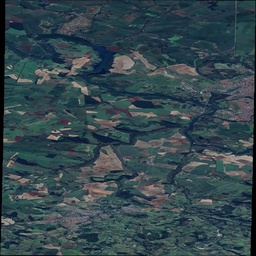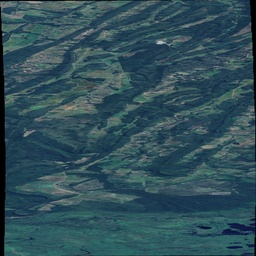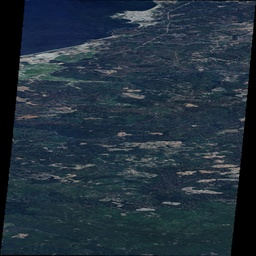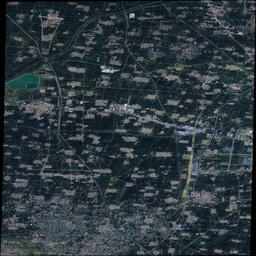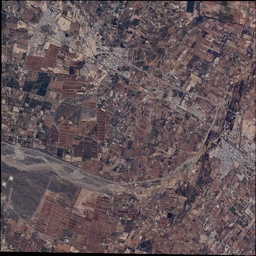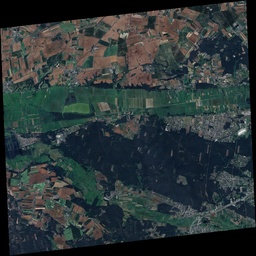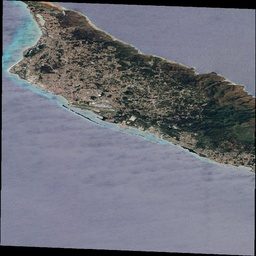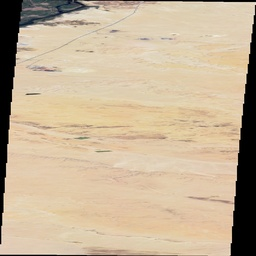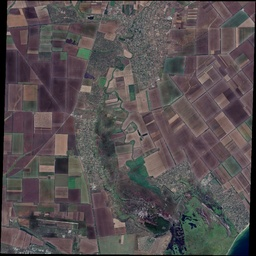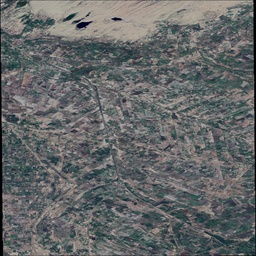

### Example rejected images

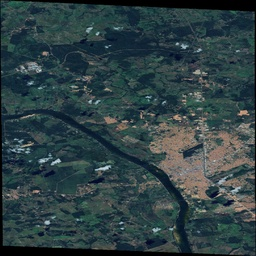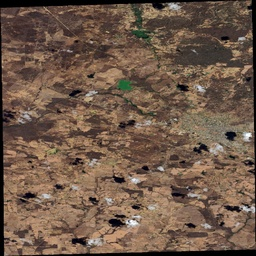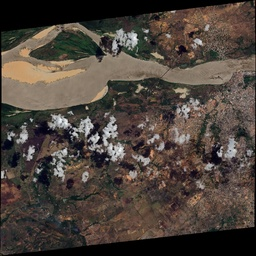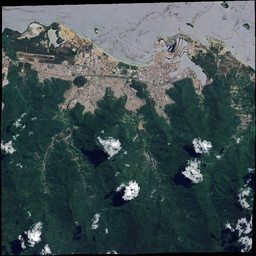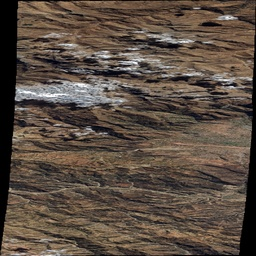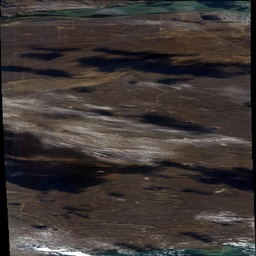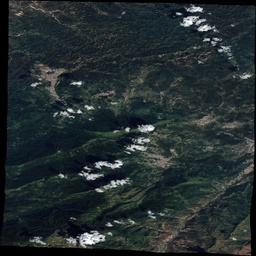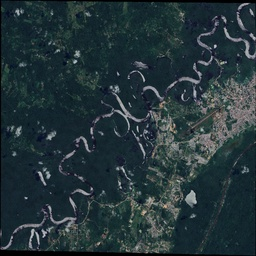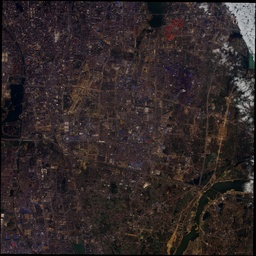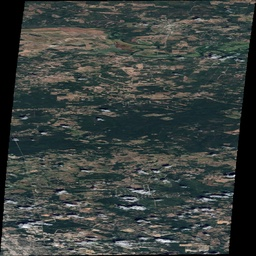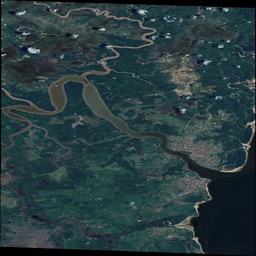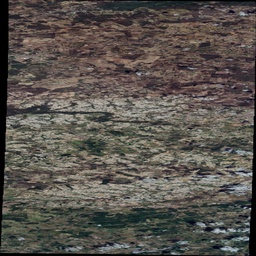

## A quick look at accepted and rejected images histograms

In [4]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Import libs
import glob
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [6]:
# constants
ACCEPTED_IMAGES_PATH_SIZE_256 = '/content/drive/MyDrive/Berkeley/capstone_project/accept_256/'
REJECTED_IMAGES_PATH_SIZE_256 = '/content/drive/MyDrive/Berkeley/capstone_project/reject_256/'

In [ ]:
def plot_images_and_histograms(image_paths):
    """
    Plots images and their RGB histograms in subplots.

    Args:
        image_paths (list): A list of paths to image files.
    """
    num_images = len(image_paths)
    if num_images == 0:
        print("No image paths provided.")
        return

    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5)) # 2 columns: image, histogram

    if num_images == 1: #if only one image, axes is not a 2d array.
        axes = [axes] #make it a list of lists.

    for i, image_path in enumerate(image_paths):
        try:
            img = mpimg.imread(image_path)

            # Display the image
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f'Image - {i}')
            axes[i, 0].axis('off')  # Turn off axis labels

            # Display the RGB histogram
            red_channel = img[:, :, 0].flatten()
            green_channel = img[:, :, 1].flatten()
            blue_channel = img[:, :, 2].flatten()

            axes[i, 1].hist(red_channel, bins=256, color='red', alpha=0.5, label='Red')
            axes[i, 1].hist(green_channel, bins=256, color='green', alpha=0.5, label='Green')
            axes[i, 1].hist(blue_channel, bins=256, color='blue', alpha=0.5, label='Blue')

            axes[i, 1].set_title(f'RGB Histogram - {i}')
            axes[i, 1].set_xlabel('Pixel Value')
            axes[i, 1].set_ylabel('Frequency')
            axes[i, 1].legend()
            axes[i, 1].grid(True, linestyle='--', alpha=0.6)

        except FileNotFoundError:
            print(f"Error: Image file not found at '{image_path}'")
        except Exception as e:
            print(f"An error occurred for '{image_path}': {e}")

    plt.tight_layout()
    plt.show()

In [13]:
# Histogram for random 10 images from drive

sample_accepted_images_256 = glob.glob(ACCEPTED_IMAGES_PATH_SIZE_256 + '*.jpeg')
sample_rejected_images_256 = glob.glob(REJECTED_IMAGES_PATH_SIZE_256 + '*.jpeg')

random.seed(42)
random_accepted_images = random.sample(sample_accepted_images_256, 3)
random_rejected_images = random.sample(sample_rejected_images_256, 3)



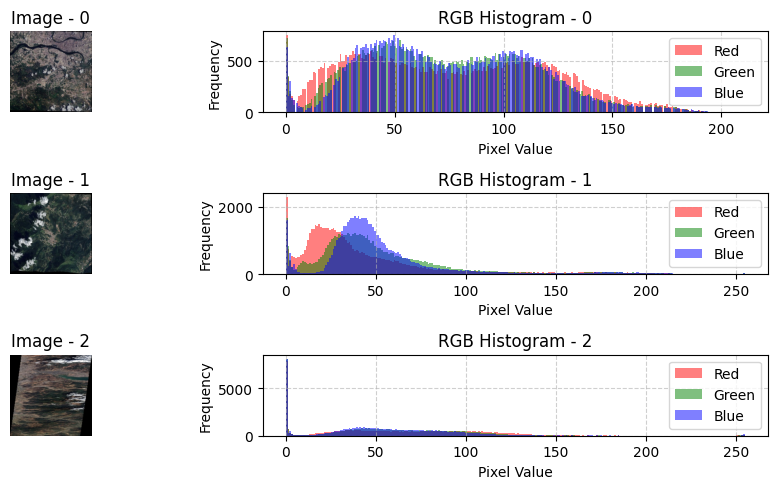

In [ ]:
plot_images_and_histograms(random_rejected_images)


# Modelling

Baseline model using a simple machine learning classifier such as a Random Forest.

In [14]:
# Load images
def load_images_from_folder(folder, label, img_size=(256, 256), flatten=True,
                            get_path_only=False):
  images = []
  labels = []
  for filename in os.listdir(folder):
      img_path = os.path.join(folder, filename)
      if not img_path.endswith(('.jpg', '.jpeg', '.png')):
          continue
      if get_path_only:
          images.append(img_path)
          labels.append(label)
      else:
        img = cv2.imread(img_path)  # Read image
        if img is not None:
            img = cv2.resize(img, img_size)  # Resize to a fixed size
            if flatten:
              img = img.flatten()  # Flatten the image to a 1D array
            images.append(img)
            labels.append(label)
  return images, labels

In [15]:
# Create flatten datasets
accepted_images, accepted_labels = load_images_from_folder(ACCEPTED_IMAGES_PATH_SIZE_256, 1)
rejected_images, rejected_labels = load_images_from_folder(REJECTED_IMAGES_PATH_SIZE_256, 0)

# Combine datasets
images = accepted_images + rejected_images
labels = accepted_labels + rejected_labels

In [16]:
# split datasets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

## RandomForest Classifier

In [17]:
# Train a simple randon forest
rf_classifier = RandomForestClassifier(n_estimators=256, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=256, random_state=42)

In [18]:
# Predict and evaluate
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.757396449704142


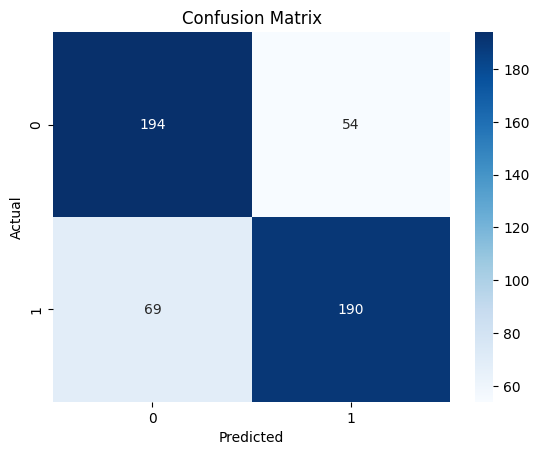

In [19]:
# create confustion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

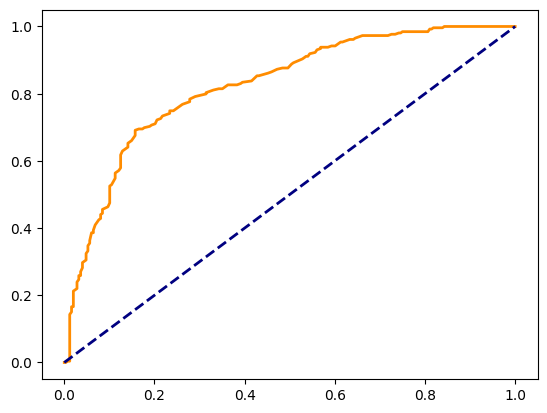

In [20]:
# Create ROC curve
from sklearn.metrics import roc_curve, auc

y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# visualize
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

### **Precision, Recall and F1 for RandomForest Classifier**


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [25]:
# create a table

data = {'Metric': ['Precision', 'Recall', 'F1 Score'],
        'Value': [precision, recall, f1]}
df = pd.DataFrame(data)
df

,Metric,Value
0,Precision,0.778689
1,Recall,0.733591
2,F1 Score,0.755467



### **Baseline Model Performance Summary**

The baseline classification model for RGB imagery was evaluated using a simple machine learning approach, leveraging scikit-learn’s `RandomForestClassifier`. The dataset consists of RGB images categorized into two classes: **Accept** (quality-approved images) and **Reject** (images with defects such as clouds, color issues, or telemetry loss).

#### **Key Findings:**
- The model was trained on a subset of the dataset and evaluated using a test split.
- Feature extraction was performed by flattening the resized images into 1D feature vectors.
- The model achieved an **accuracy score of 0.76** on the test set.

#### **Insights:**
- A higher accuracy score suggests that the model effectively distinguishes between acceptable and defective images.
- However, relying solely on raw pixel values may limit the model's ability to generalize.
- Further improvements can be achieved by incorporating advanced feature extraction techniques such as **color histograms, texture analysis (GLCM), and PCA for dimensionality reduction**.
- Additional tuning through **hyperparameter optimization, ensemble methods, and deep learning models (e.g., CNNs)** may yield better results.

#### **Next Steps:**
- **Experiment with alternative feature extraction techniques** to enhance model performance.
- **Optimize model parameters** using GridSearchCV or RandomizedSearchCV.
- **Evaluate additional metrics**, such as precision, recall, and F1-score, to ensure a balanced classification.



## Convolutional Neural Network (CNN)

In [7]:
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


# Load Data

Create train and test data

In [8]:
# Define directories
cloudy_dir = '/content/drive/MyDrive/Berkeley/capstone_project/reject_256'
non_cloudy_dir = '/content/drive/MyDrive/Berkeley/capstone_project/accept_256'

# Image dimensions and batch size
img_width, img_height = 256, 256
batch_size = 32

# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Berkeley/capstone_project/data',  # Parent directory containing both cloudy and non-cloudy folders
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Binary classification (cloudy vs non-cloudy)
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Berkeley/capstone_project/data',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 2026 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [9]:
# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [23]:
# Train the model
epochs = 30  # You can adjust the number of epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)
model.save(f'/content/drive/MyDrive/Berkeley/capstone_project/cloud_detection_model_epoch_{epochs}.h5')

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 738ms/step - accuracy: 0.7203 - loss: 0.5719 - val_accuracy: 0.6562 - val_loss: 0.6468
Epoch 2/30
 1/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7188 - loss: 0.4719

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.7188 - loss: 0.4719 - val_accuracy: 0.6854 - val_loss: 0.5949
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7613 - loss: 0.5120 - val_accuracy: 0.7458 - val_loss: 0.5394
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.6875 - loss: 0.6028 - val_accuracy: 0.7208 - val_loss: 0.5561
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.7928 - loss: 0.4835 - val_accuracy: 0.7937 - val_loss: 0.4553
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.8438 - loss: 0.4388 - val_accuracy: 0.7854 - val_loss: 0.4674
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8101 - loss: 0.4559 - val_accuracy: 0.8042 - val_loss: 0.4566
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.6875 - loss: 0.6499 - val_accuracy: 0.8083 - val_loss: 0.4402
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.8144 - loss: 0.4399 - val_accuracy: 0.8167 - val_loss:

### Plot Optionally, plot training history.

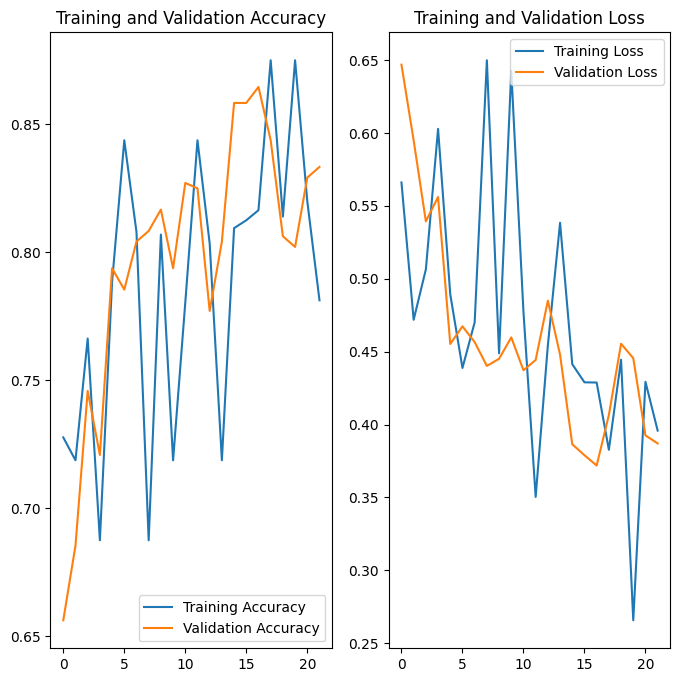

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
# create a dataframe
df = pd.DataFrame({'accuracy': acc, 'validation_accuracy': val_acc, 'loss': loss, 'val_loss': val_loss})

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# Print dataframe
# evaluate the model
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)
train_loss, train_acc = model.evaluate(train_generator)
print('Train accuracy:', train_acc)

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 481ms/step - accuracy: 0.8251 - loss: 0.4253
Test accuracy: 0.8438735008239746
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 758ms/step - accuracy: 0.8408 - loss: 0.4082
Train accuracy: 0.8316880464553833


### **CNN Model Performance Summary**
- The model was trained for 30 epochs.
- Training and validation accuracy improved over epochs, showing that the model learned to classify the images.
- The training accuracy reached approximately 87%, and the validation accuracy reached approximately 83% by the end of training.
- Both training and validation loss decreased, indicating that the model effectively learned the underlying patterns in the data.

### Test Performance
- The model was evaluated on the validation dataset.
- The test accuracy was approximately 83%, which is similar to the final validation accuracy.
- The train accuracy was approximately 87%.

### Summary

The CNN model demonstrated good performance on the image classification task. The training metrics indicate that the model learned effectively, and the test accuracy suggests that it generalizes reasonably well to unseen data.

The model uses a relatively simple architecture and yet achieves high accuracy. This suggests that the features learned by the CNN are effective for this classification task.

### Next Steps

While the model performs well, there are several avenues for further improvement:

* **Further Hyperparameter Tuning**: Experimenting with different learning rates, batch sizes, optimizers, or the number of epochs could lead to better results.
* **Model Architecture Exploration**: Trying deeper or more complex CNN architectures might capture more intricate patterns in the images.
* **Data Augmentation**: Applying more aggressive data augmentation techniques could help to improve the model's generalization and robustness.
* **Additional Data**: Training the model on a larger and more diverse dataset could further enhance its performance.